In [1]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory) 
sys.path.append(parent_directory)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
from preprocess.BaselinePrerocess import baseline_process, gcn_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process
from preprocess.GraphTransformerPrerocess import graph_global_transformer_local_process
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology, graph_topology_5
from tensorflow.keras.models import load_model
from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1
from postprocess.errors import estimate_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from math import sqrt
from spektral.layers import GCNConv
from baselines.tcn import TCN
from preprocess.helper import series_to_supervised
import time

2023-08-12 22:21:52.295077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 22:21:53.608943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Preprocessing

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


## MAE and RMSE

In [7]:
saved_models = ['WaLeF_mlp', 'WaLeF_rnn', 'WaLeF_cnn', 'WaLeF_rcnn', 'WaLeF_transformer']


for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    if saved_models[i] == 'WaLeF_transformer':
        # load model and make prediction
        model = load_model('../saved_models/{}.h5'.format(saved_models[i]))
        start_time = time.perf_counter()
        yhat = model.predict(test_X_mask)
        end_time = time.perf_counter()
        used_time = end_time - start_time
        print(f"Usded time: {used_time} seconds")
    else:
        # load model and make prediction
        start_time = time.perf_counter()
        model = load_model('../saved_models/{}.h5'.format(saved_models[i]))
        yhat = model.predict(test_X_mask)
        end_time = time.perf_counter()
        used_time = end_time - start_time
        print(f"Usded time: {used_time} seconds")

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_yhat = inv_yhat[:, [0, 24, 48, 72]]
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    inv_y = inv_y[:, [0, 24, 48, 72]]
    
    print(inv_y.shape)
    # compute MAE and RMSE
    print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
    print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))
    
    errors = inv_yhat - inv_y
    print('Numbers of over/under estimate:', estimate_error(errors))
    

===================== WaLeF_mlp =====================
603/603 [==============================] - 1s 2ms/step
Usded time: 1.8807713752612472 seconds
(19268, 4)
MAE = 0.06
RMSE = 0.0795
Numbers of over/under estimate: (27654, 49418)
===================== WaLeF_rnn =====================
603/603 [==============================] - 8s 13ms/step
Usded time: 8.5746970619075 seconds
(19268, 4)
MAE = 0.0529
RMSE = 0.0708
Numbers of over/under estimate: (33273, 43799)
===================== WaLeF_cnn =====================
603/603 [==============================] - 1s 2ms/step
Usded time: 1.934706007130444 seconds
(19268, 4)
MAE = 0.0753
RMSE = 0.1047
Numbers of over/under estimate: (22880, 54192)
===================== WaLeF_rcnn =====================
603/603 [==============================] - 8s 13ms/step
Usded time: 8.619614268187433 seconds
(19268, 4)
MAE = 0.1211
RMSE = 0.138
Numbers of over/under estimate: (4112, 72960)
===================== WaLeF_transformer =====================
603/603 [===

### TCN

In [9]:
saved_models = ['WaLeF_tcn']

for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    # load model and make prediction
    model = load_model('../saved_models/{}.h5'.format(saved_models[i]), custom_objects={'TCN': TCN})
    start_time = time.perf_counter()
    yhat = model.predict(test_X_mask)
    end_time = time.perf_counter()
    used_time = end_time - start_time
    print(f"Usded time: {used_time} seconds")
        
    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_yhat = inv_yhat[:, [0, 24, 48, 72]]
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    inv_y = inv_y[:, [0, 24, 48, 72]]

    # compute MAE and RMSE
    print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
    print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))
    
    errors = inv_yhat - inv_y
    print('Numbers of over/under estimate:', estimate_error(errors))

===================== WaLeF_tcn =====================
603/603 [==============================] - 4s 5ms/step
Usded time: 4.575373043771833 seconds
MAE = 0.0435
RMSE = 0.0588
Numbers of over/under estimate: (25347, 51725)


### GCN

In [10]:
train_X_mask_gcn, val_X_mask_gcn, test_X_mask_gcn, \
train_ws_y_gcn, val_ws_y_gcn, test_ws_y_gcn, \
scaler, ws_scaler = gcn_process(n_hours, K, masked_value, split_1, split_2)
print(train_X_mask_gcn.shape, val_X_mask_gcn.shape, test_X_mask_gcn.shape, train_ws_y_gcn.shape, val_ws_y_gcn.shape, test_ws_y_gcn.shape)


train_adj_mat, val_adj_mat, test_adj_mat \
= graph_topology(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))
print(train_adj_mat.shape, val_adj_mat.shape, test_adj_mat.shape)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(77069, 14, 96) (9634, 14, 96) (19268, 14, 96) (77069, 96) (9634, 96) (19268, 96)
node_indices: [ 0  0  0  0  0  1  1  1  2  2  2  3  3  4  4  4  4  5  5  5  6  6  6  7
  7  7  8  8  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13] 
neighbor_indices: [ 1  4  8 12 13  1  4 13  3  4 13  2 13  0  1  2 13  7  8 13  7  8 13  5
  6 13  0  5  6 12 13 11 12 13 11 12 13  9 10 13  0  9 10 13  0  1  2  3
  4  5  6  7  8  9 10 11 12 13]
number of nodes: 14, number of edges: 58
(77069, 14, 14) (9634, 14, 14) (19268, 14, 14)


In [11]:
saved_models = ['WaLeF_gcn']

for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    # load model and make prediction
    model = load_model('../saved_models/{}.h5'.format(saved_models[i]), custom_objects={'GCNConv': GCNConv})
    start_time = time.perf_counter()
    yhat = model.predict([test_X_mask_gcn, test_adj_mat])
    end_time = time.perf_counter()
    used_time = end_time - start_time
    print(f"Usded time: {used_time} seconds")

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_yhat = inv_yhat[:, [0, 24, 48, 72]]
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    inv_y = inv_y[:, [0, 24, 48, 72]]

    # compute MAE and RMSE
    print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
    print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))
    
    errors = inv_yhat - inv_y
    print('Numbers of over/under estimate:', estimate_error(errors))

===================== WaLeF_gcn =====================
603/603 [==============================] - 3s 4ms/step
Usded time: 3.1302956151776016 seconds
MAE = 0.0521
RMSE = 0.0698
Numbers of over/under estimate: (33184, 43888)


### FloodGTN

In [12]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_water_transformer_cov_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [13]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


In [14]:
saved_models = ['WaLeF_gtn_p_1']

for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    # load model and make prediction
    model = load_model('../saved_models/{}.h5'.format(saved_models[i]), custom_objects={'GCNConv': GCNConv})
    start_time = time.perf_counter()
    yhat = model.predict([test_cov, test_tws_reshape, test_adj_mat])
    end_time = time.perf_counter()
    used_time = end_time - start_time
    print(f"Usded time: {used_time} seconds")

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_yhat = inv_yhat[:, [0, 24, 48, 72]]
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    inv_y = inv_y[:, [0, 24, 48, 72]]

    # compute MAE and RMSE
    print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
    print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))
    
    errors = inv_yhat - inv_y
    print('Numbers of over/under estimate:', estimate_error(errors))

===================== WaLeF_gtn_p_1 =====================
603/603 [==============================] - 2s 3ms/step
Usded time: 2.9516146890819073 seconds
MAE = 0.0694
RMSE = 0.0871
Numbers of over/under estimate: (13202, 63870)


## Flood time steps and areas

### Ground-truth water levels and flooding time steps and flooding areas


In [6]:
upper_threshold = 3.5
lower_threshold = 0
t1 = 1

inv_y = ws_scaler.inverse_transform(test_ws_y)
inv_y_reshape = inv_y.reshape((-1, 24, 4))

print("Over thresholds:", flood_threshold_t1(inv_y_reshape, t1, upper_threshold))
print("Under thresholds:", drought_threshold_t1(inv_y_reshape, t1, lower_threshold))

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1346
S1, S25A, S25B, S26 areas: -385.8:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
Under thresholds: None


In [7]:
train_X_mask, val_X_mask, test_X_mask, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, gate_pump_scaler, ws_scaler = baseline_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(96337, 96, 16)
(96337, 24, 7)
(96337, 24, 4)
Train/val/test X with mask: (77069, 1536) (9634, 1536) (19268, 1536) 
 Train/val/test gate pump true: (77069, 168) (9634, 168) (19268, 168) 
 Train/val/test ws true: (77069, 96) (9634, 96) (19268, 96)
Train/val/test X with mask: (77069, 96, 16) (9634, 96, 16) (19268, 96, 16) 
 Train/val/test gate pump y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7) 
 Train/val/test ws y: (77069, 96) (9634, 96) (19268, 96)


In [8]:
saved_models = ['WaLeF_mlp', 'WaLeF_rnn', 'WaLeF_cnn', 'WaLeF_rcnn', 'WaLeF_transformer']


for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    if saved_models[i] == 'WaLeF_transformer':
        # load model and make prediction
        model = load_model('../saved_models/{}.h5'.format(saved_models[i]))
        yhat = model.predict(test_X_mask)
    else:
        # load model and make prediction
        model = load_model('../saved_models/{}.h5'.format(saved_models[i]))
        yhat = model(test_X_mask)

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    
    # compute time steps and areas over and under thresholds
    inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
    inv_y_reshape = inv_y.reshape((-1, 24, 4))
    
    print("Over thresholds:", flood_threshold_t1(inv_yhat_reshape, t1, upper_threshold))
    print("Under thresholds:", drought_threshold_t1(inv_yhat_reshape, t1, lower_threshold))

===================== WaLeF_mlp =====================


2023-08-10 23:24:30.887772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1


S1, S25A, S25B, S26 time steps: 147, 206, 85, 462
S1, S25A, S25B, S26 areas: 27.969, 46.4817, 14, 157.7972
TOTAL time steps: 900; TOTAL areas: 245.7588
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1677
S1, S25A, S25B, S26 areas: -500.4079:
TOTAL time steps: 5493; TOTAL areas: -1536.2236
--------------------------------------------------
Under thresholds: None
===================== WaLeF_rnn =====================
S1, S25A, S25B, S26 time steps: 110, 109, 68, 90
S1, S25A, S25B, S26 areas: 17.1235, 16.9153, 9, 14.4063
TOTAL time steps: 377; TOTAL areas: 57.3205
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1527
S1, S25A, S25B, S26 areas: -441.4119:
TOTAL time steps: 4813; TOTAL areas: -1308.2892
--------------------------------------------------
Under thresholds: None
===================== WaLeF_cnn =====================


2023-08-10 23:24:33.008262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


S1, S25A, S25B, S26 time steps: 58, 59, 32, 193
S1, S25A, S25B, S26 areas: 5.9064, 7.2146, 3, 37.786
TOTAL time steps: 342; TOTAL areas: 53.6915
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1491
S1, S25A, S25B, S26 areas: -413.2299:
TOTAL time steps: 5182; TOTAL areas: -1394.055
--------------------------------------------------
Under thresholds: None
===================== WaLeF_rcnn =====================
S1, S25A, S25B, S26 time steps: 37, 36, 47, 168
S1, S25A, S25B, S26 areas: 4.6066, 3.6786, 5, 31.4141
TOTAL time steps: 288; TOTAL areas: 45.1064
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1829
S1, S25A, S25B, S26 areas: -553.2019:
TOTAL time steps: 5631; TOTAL areas: -1555.6328
--------------------------------------------------
Under thresholds: None
===================== WaLeF_transformer =====================
603/603 [==============================] - 2s 3ms/ste

In [9]:
saved_models = ['WaLeF_tcn']

for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    # load model and make prediction
    model = load_model('../saved_models/{}.h5'.format(saved_models[i]), custom_objects={'TCN': TCN})
    yhat = model(test_X_mask)

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    
    # compute time steps and areas over and under thresholds
    inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
    inv_y_reshape = inv_y.reshape((-1, 24, 4))
    
    print("Over thresholds:", flood_threshold_t1(inv_yhat_reshape, t1, upper_threshold))
    print("Under thresholds:", drought_threshold_t1(inv_yhat_reshape, t1, lower_threshold))

===================== WaLeF_tcn =====================
S1, S25A, S25B, S26 time steps: 34, 84, 36, 181
S1, S25A, S25B, S26 areas: 3.259, 11.2409, 4, 30.073
TOTAL time steps: 335; TOTAL areas: 48.3725
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1656
S1, S25A, S25B, S26 areas: -465.9271:
TOTAL time steps: 5479; TOTAL areas: -1470.4138
--------------------------------------------------
Under thresholds: None


### GCN

In [10]:
train_X_mask_gcn, val_X_mask_gcn, test_X_mask_gcn, \
train_ws_y_gcn, val_ws_y_gcn, test_ws_y_gcn, \
scaler, ws_scaler = gcn_process(n_hours, K, masked_value, split_1, split_2)
print(train_X_mask_gcn.shape, val_X_mask_gcn.shape, test_X_mask_gcn.shape, train_ws_y_gcn.shape, val_ws_y_gcn.shape, test_ws_y_gcn.shape)


train_adj_mat, val_adj_mat, test_adj_mat \
= graph_topology(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))
print(train_adj_mat.shape, val_adj_mat.shape, test_adj_mat.shape)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(77069, 14, 96) (9634, 14, 96) (19268, 14, 96) (77069, 96) (9634, 96) (19268, 96)
node_indices: [ 0  0  0  0  0  1  1  1  2  2  2  3  3  4  4  4  4  5  5  5  6  6  6  7
  7  7  8  8  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13] 
neighbor_indices: [ 1  4  8 12 13  1  4 13  3  4 13  2 13  0  1  2 13  7  8 13  7  8 13  5
  6 13  0  5  6 12 13 11 12 13 11 12 13  9 10 13  0  9 10 13  0  1  2  3
  4  5  6  7  8  9 10 11 12 13]
number of nodes: 14, number of edges: 58
(77069, 14, 14) (9634, 14, 14) (19268, 14, 14)


In [11]:
saved_models = ['WaLeF_gcn']

for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    # load model and make prediction
    model = load_model('../saved_models/{}.h5'.format(saved_models[i]), custom_objects={'GCNConv': GCNConv})
    yhat = model([test_X_mask_gcn, test_adj_mat])

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_y = ws_scaler.inverse_transform(test_ws_y)

    # compute time steps and areas over and under thresholds
    inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
    inv_y_reshape = inv_y.reshape((-1, 24, 4))
    
    print("Over thresholds:", flood_threshold_t1(inv_yhat_reshape, t1, upper_threshold))
    print("Under thresholds:", drought_threshold_t1(inv_yhat_reshape, t1, lower_threshold))

===================== WaLeF_gcn =====================
S1, S25A, S25B, S26 time steps: 102, 120, 79, 192
S1, S25A, S25B, S26 areas: 15.9006, 19.8369, 9, 36.1276
TOTAL time steps: 493; TOTAL areas: 81.288
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1569
S1, S25A, S25B, S26 areas: -462.6266:
TOTAL time steps: 5170; TOTAL areas: -1454.7836
--------------------------------------------------
Under thresholds: None


### FloodGTN-Parallel

In [12]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)
node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


In [13]:
saved_models = ['WaLeF_gtn_p_1']

for i in range(len(saved_models)):
    print("===================== {} =====================".format(saved_models[i]))
    
    # load model and make prediction
    model = load_model('../saved_models/{}.h5'.format(saved_models[i]), custom_objects={'GCNConv': GCNConv}
                      )
    yhat = model.predict([test_cov, test_tws_reshape, test_adj_mat])

    # inverse transformation
    inv_yhat = ws_scaler.inverse_transform(yhat)
    inv_y = ws_scaler.inverse_transform(test_ws_y)
    
    # compute time steps and areas over and under thresholds
    inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
    inv_y_reshape = inv_y.reshape((-1, 24, 4))
    
    print("Over thresholds:", flood_threshold_t1(inv_yhat_reshape, t1, upper_threshold))
    print("Under thresholds:", drought_threshold_t1(inv_yhat_reshape, t1, lower_threshold))

===================== WaLeF_gtn_p_1 =====================
603/603 [==============================] - 3s 3ms/step
S1, S25A, S25B, S26 time steps: 88, 111, 85, 152
S1, S25A, S25B, S26 areas: 14.1525, 19.7347, 13, 26.7103
TOTAL time steps: 436; TOTAL areas: 73.9788
--------------------------------------------------
Over thresholds: None
S1, S25A, S25B, S26 time steps: 1553
S1, S25A, S25B, S26 areas: -460.4907:
TOTAL time steps: 5270; TOTAL areas: -1493.4596
--------------------------------------------------
Under thresholds: None


### HEC-RAS

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from preprocess.helper import stage_series_to_supervised, series_to_supervised

In [54]:
error_ras = pd.read_csv('../data/ras_1920.csv', index_col=0)
error_ras.reset_index(drop=True, inplace=True)
error_ras

,S1_OBS,S1_RAS,S1_ERROR,S25A_TW_OBS,S25A_TW_RAS,S25A_TW_ERROR,S25B_TW_OBS,S25B_TW_RAS,S25B_TW_ERROR,S26_TW_OBS,S26_TW_RAS,S26_TW_ERROR
0,-0.32,-0.54,-0.22,-0.31,-0.54,-0.23,-0.28,-0.53,-0.25,-0.30,-0.54,-0.24
1,0.17,-0.05,-0.22,0.14,-0.05,-0.19,0.19,-0.05,-0.24,0.19,-0.05,-0.24
2,0.80,0.62,-0.18,0.76,0.61,-0.15,0.83,0.63,-0.20,0.80,0.63,-0.17
3,1.26,1.09,-0.17,1.27,1.10,-0.17,1.31,1.10,-0.21,1.28,1.08,-0.20
4,1.68,1.51,-0.17,1.67,1.53,-0.14,1.70,1.51,-0.19,1.69,1.52,-0.17
...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.18,0.21,0.03,0.13,0.22,0.09,0.26,0.22,-0.04,0.17,0.20,0.03
17540,0.52,0.69,0.17,0.52,0.68,0.16,0.60,0.67,0.07,0.54,0.79,0.25
17541,1.14,1.13,-0.01,1.18,1.14,-0.04,1.17,1.13,-0.04,1.25,1.14,-0.11
17542,1.62,1.67,0.05,1.65,1.67,0.02,1.70,1.69,-0.01,1.67,1.67,0.00


In [55]:
ras_concat = pd.concat([error_ras.loc[:, 'S1_RAS'], error_ras.loc[:, 'S25A_TW_RAS'], error_ras.loc[:, 'S25B_TW_OBS'], error_ras.loc[:, 'S26_TW_RAS']], axis=1)
ras_concat = pd.DataFrame(ras_concat)
ras_concat

,S1_RAS,S25A_TW_RAS,S25B_TW_OBS,S26_TW_RAS
0,-0.54,-0.54,-0.28,-0.54
1,-0.05,-0.05,0.19,-0.05
2,0.62,0.61,0.83,0.63
3,1.09,1.10,1.31,1.08
4,1.51,1.53,1.70,1.52
...,...,...,...,...
17539,0.21,0.22,0.26,0.20
17540,0.69,0.68,0.60,0.79
17541,1.13,1.14,1.17,1.14
17542,1.67,1.67,1.70,1.67


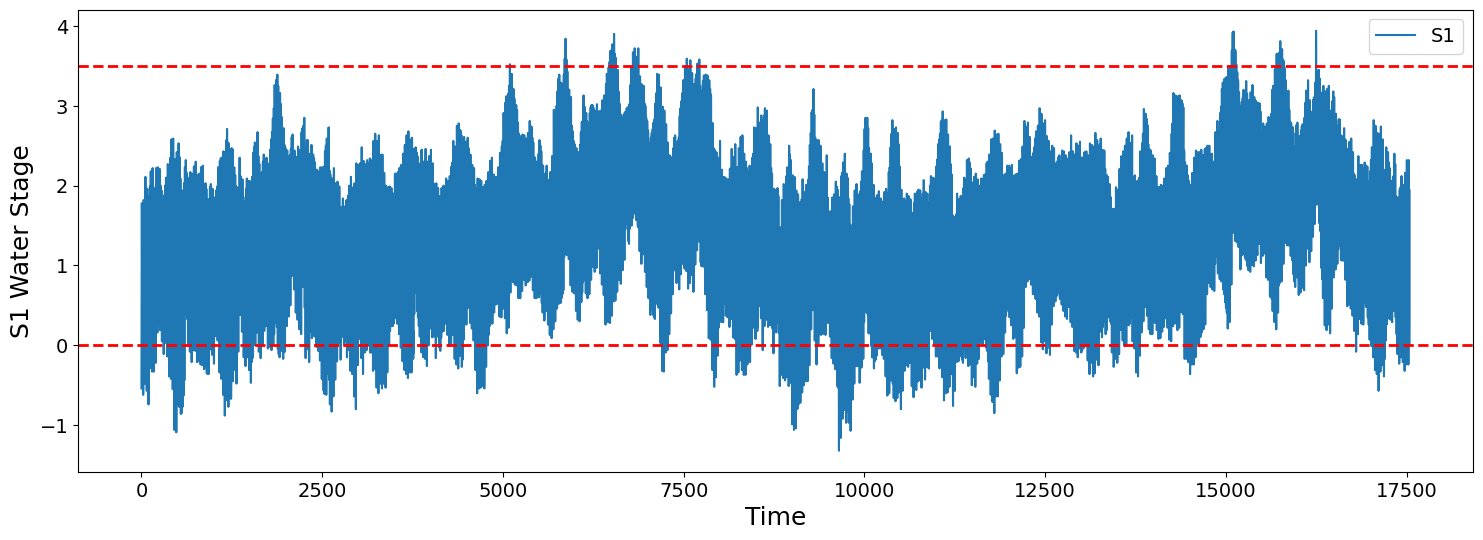

In [56]:
plt.rcParams["figure.figsize"] = (18, 6)
plt.plot(ras_concat.iloc[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [50]:
ras_concat['Timestamp'] = test_set_s1['Time']
ras_concat

,S1_RAS,S25A_TW_RAS,S25B_TW_OBS,S26_TW_RAS,Timestamp
0,-0.54,-0.54,-0.28,-0.54,10/19/18 09:00
1,-0.05,-0.05,0.19,-0.05,10/19/18 10:00
2,0.62,0.61,0.83,0.63,10/19/18 11:00
3,1.09,1.10,1.31,1.08,10/19/18 12:00
4,1.51,1.53,1.70,1.52,10/19/18 13:00
...,...,...,...,...,...
17539,0.21,0.22,0.26,0.20,10/19/20 04:00
17540,0.69,0.68,0.60,0.79,10/19/20 05:00
17541,1.13,1.14,1.17,1.14,10/19/20 06:00
17542,1.67,1.67,1.70,1.67,10/19/20 07:00


In [51]:
ras_flood = ras_concat[ras_concat['S1_RAS'] > 3.5]
ras_flood

,S1_RAS,S25A_TW_RAS,S25B_TW_OBS,S26_TW_RAS,Timestamp
5097,3.52,3.50,3.28,3.43,5/19/19 18:00
5855,3.59,3.58,3.38,3.64,6/20/19 08:00
5866,3.52,3.50,3.14,3.59,6/20/19 19:00
5867,3.84,3.83,3.45,3.78,6/20/19 20:00
5868,3.57,3.56,3.47,3.59,6/20/19 21:00
...,...,...,...,...,...
15803,3.56,3.56,3.66,3.55,8/7/20 20:00
15804,3.56,3.56,3.88,3.57,8/7/20 21:00
16247,3.65,3.67,2.46,3.59,8/26/20 08:00
16249,3.94,3.94,3.12,4.13,8/26/20 10:00


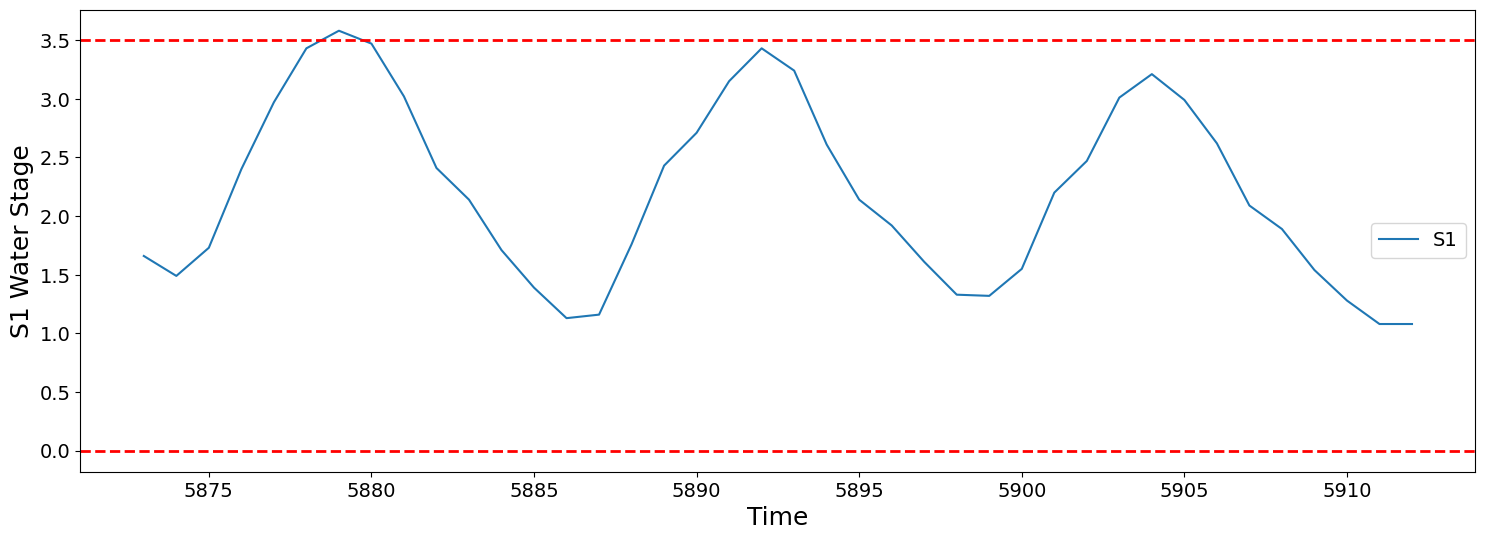

In [38]:
plt.rcParams["figure.figsize"] = (18, 6)
plt.plot(ras_concat.iloc[5873:5913, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Test_set

In [39]:
test_set = pd.read_csv('../data/test_data.csv')
test_set.columns

Index(['Time', 'WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A',
       'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B',
       'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2',
       'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')

In [40]:
# test_set_s1 = test_set.iloc[-17544:, 0:2]
test_set_s1 = test_set.iloc[:, 0:2]
test_set_s1.reset_index(drop=True, inplace=True)
test_set_s1

,Time,WS_S1
0,10/19/18 09:00,0.58
1,10/19/18 10:00,0.34
2,10/19/18 11:00,0.24
3,10/19/18 12:00,0.38
4,10/19/18 13:00,0.74
...,...,...
19306,12/31/20 19:00,1.24
19307,12/31/20 20:00,1.62
19308,12/31/20 21:00,1.98
19309,12/31/20 22:00,2.13


In [41]:
filter_flood = test_set_s1[test_set_s1['WS_S1'] > 3.5]
filter_flood

,Time,WS_S1
7647,9/3/19 00:00,3.59
7658,9/3/19 11:00,3.54
7659,9/3/19 12:00,3.76
7660,9/3/19 13:00,3.70
7671,9/4/19 00:00,3.65
...,...,...
18043,11/9/20 04:00,3.56
18054,11/9/20 15:00,3.55
18055,11/9/20 16:00,3.60
18056,11/9/20 17:00,3.51


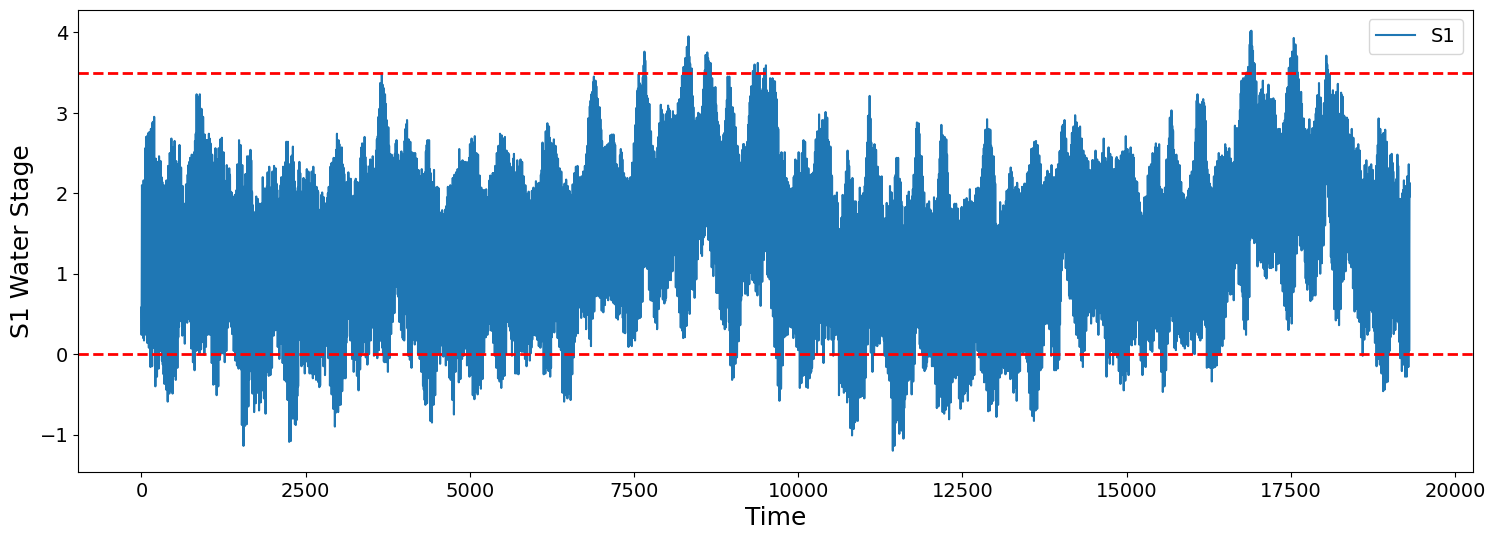

In [42]:
plt.rcParams["figure.figsize"] = (18, 6)
plt.plot(test_set_s1['WS_S1'], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [43]:
filter_flood.index

Index([ 7647,  7658,  7659,  7660,  7671,  7672,  8255,  8268,  8280,  8281,
        8292,  8293,  8304,  8305,  8306,  8317,  8318,  8329,  8330,  8331,
        8342,  8355,  8380,  8579,  8590,  8591,  8592,  8603,  8604,  8615,
        8616,  8627,  8628,  8639,  8640,  8641,  8652,  8664,  8665,  9311,
        9335,  9336,  9385,  9484,  9509, 16850, 16851, 16874, 16875, 16876,
       16886, 16887, 16888, 16889, 16899, 16900, 16901, 16911, 16912, 16913,
       16924, 16925, 16926, 16937, 16938, 16950, 17471, 17484, 17496, 17497,
       17508, 17509, 17521, 17522, 17533, 17534, 17545, 17546, 17547, 17557,
       17558, 17559, 17570, 17571, 17572, 17582, 17583, 17595, 17596, 18041,
       18042, 18043, 18054, 18055, 18056, 18067],
      dtype='int64')

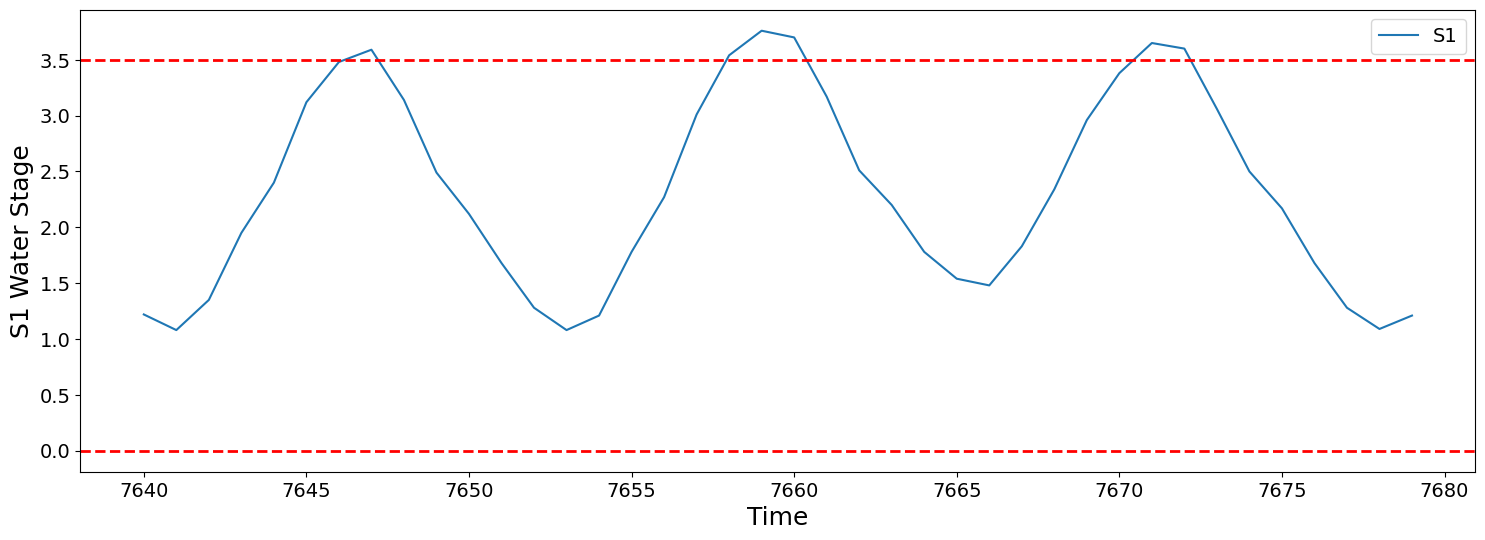

In [44]:
plt.rcParams["figure.figsize"] = (18, 6)
plt.plot(test_set_s1.iloc[7640:7680, 1], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [45]:
test_set_s1.iloc[7640:7680, 0]

7640    9/2/19 17:00
7641    9/2/19 18:00
7642    9/2/19 19:00
7643    9/2/19 20:00
7644    9/2/19 21:00
7645    9/2/19 22:00
7646    9/2/19 23:00
7647    9/3/19 00:00
7648    9/3/19 01:00
7649    9/3/19 02:00
7650    9/3/19 03:00
7651    9/3/19 04:00
7652    9/3/19 05:00
7653    9/3/19 06:00
7654    9/3/19 07:00
7655    9/3/19 08:00
7656    9/3/19 09:00
7657    9/3/19 10:00
7658    9/3/19 11:00
7659    9/3/19 12:00
7660    9/3/19 13:00
7661    9/3/19 14:00
7662    9/3/19 15:00
7663    9/3/19 16:00
7664    9/3/19 17:00
7665    9/3/19 18:00
7666    9/3/19 19:00
7667    9/3/19 20:00
7668    9/3/19 21:00
7669    9/3/19 22:00
7670    9/3/19 23:00
7671    9/4/19 00:00
7672    9/4/19 01:00
7673    9/4/19 02:00
7674    9/4/19 03:00
7675    9/4/19 04:00
7676    9/4/19 05:00
7677    9/4/19 06:00
7678    9/4/19 07:00
7679    9/4/19 08:00
Name: Time, dtype: object

In [57]:
n_hours = 72
K = 24

In [58]:
data_supervised = series_to_supervised(ras_concat, n_hours, K)
data_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
72,-0.54,-0.54,-0.28,-0.54,-0.05,-0.05,0.19,-0.05,0.62,0.61,...,1.84,1.44,0.83,0.82,1.32,0.83,0.31,0.32,0.83,0.32
73,-0.05,-0.05,0.19,-0.05,0.62,0.61,0.83,0.63,1.09,1.10,...,1.32,0.83,0.31,0.32,0.83,0.32,-0.25,-0.23,0.29,-0.26
74,0.62,0.61,0.83,0.63,1.09,1.10,1.31,1.08,1.51,1.53,...,0.83,0.32,-0.25,-0.23,0.29,-0.26,-0.67,-0.66,-0.23,-0.67
75,1.09,1.10,1.31,1.08,1.51,1.53,1.70,1.52,1.78,1.78,...,0.29,-0.26,-0.67,-0.66,-0.23,-0.67,-0.74,-0.73,-0.51,-0.73
76,1.51,1.53,1.70,1.52,1.78,1.78,1.97,1.80,1.77,1.77,...,-0.23,-0.67,-0.74,-0.73,-0.51,-0.73,-0.66,-0.66,-0.47,-0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17516,1.75,1.74,2.03,1.79,1.23,1.22,1.59,1.26,0.78,0.76,...,0.43,0.11,0.00,0.00,0.23,0.00,0.21,0.22,0.26,0.20
17517,1.23,1.22,1.59,1.26,0.78,0.76,1.05,0.82,0.22,0.24,...,0.23,0.00,0.21,0.22,0.26,0.20,0.69,0.68,0.60,0.79
17518,0.78,0.76,1.05,0.82,0.22,0.24,0.72,0.20,-0.19,-0.19,...,0.26,0.20,0.69,0.68,0.60,0.79,1.13,1.14,1.17,1.14
17519,0.22,0.24,0.72,0.20,-0.19,-0.19,0.19,-0.18,-0.21,-0.25,...,0.60,0.79,1.13,1.14,1.17,1.14,1.67,1.67,1.70,1.67


In [59]:
col_names = ['S1_RAS', 'S25A_TW_RAS', 'S25B_TW_OBS', 'S26_TW_RAS'] * (n_hours+K)
    
data_supervised.reset_index(drop=True, inplace=True)
data_supervised.columns = [[i + '_' + j for i, j in zip(col_names, list(data_supervised.columns))]]
data_supervised



,S1_RAS_var1(t-72),S25A_TW_RAS_var2(t-72),S25B_TW_OBS_var3(t-72),S26_TW_RAS_var4(t-72),S1_RAS_var1(t-71),S25A_TW_RAS_var2(t-71),S25B_TW_OBS_var3(t-71),S26_TW_RAS_var4(t-71),S1_RAS_var1(t-70),S25A_TW_RAS_var2(t-70),...,S25B_TW_OBS_var3(t+21),S26_TW_RAS_var4(t+21),S1_RAS_var1(t+22),S25A_TW_RAS_var2(t+22),S25B_TW_OBS_var3(t+22),S26_TW_RAS_var4(t+22),S1_RAS_var1(t+23),S25A_TW_RAS_var2(t+23),S25B_TW_OBS_var3(t+23),S26_TW_RAS_var4(t+23)
0,-0.54,-0.54,-0.28,-0.54,-0.05,-0.05,0.19,-0.05,0.62,0.61,...,1.84,1.44,0.83,0.82,1.32,0.83,0.31,0.32,0.83,0.32
1,-0.05,-0.05,0.19,-0.05,0.62,0.61,0.83,0.63,1.09,1.10,...,1.32,0.83,0.31,0.32,0.83,0.32,-0.25,-0.23,0.29,-0.26
2,0.62,0.61,0.83,0.63,1.09,1.10,1.31,1.08,1.51,1.53,...,0.83,0.32,-0.25,-0.23,0.29,-0.26,-0.67,-0.66,-0.23,-0.67
3,1.09,1.10,1.31,1.08,1.51,1.53,1.70,1.52,1.78,1.78,...,0.29,-0.26,-0.67,-0.66,-0.23,-0.67,-0.74,-0.73,-0.51,-0.73
4,1.51,1.53,1.70,1.52,1.78,1.78,1.97,1.80,1.77,1.77,...,-0.23,-0.67,-0.74,-0.73,-0.51,-0.73,-0.66,-0.66,-0.47,-0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17444,1.75,1.74,2.03,1.79,1.23,1.22,1.59,1.26,0.78,0.76,...,0.43,0.11,0.00,0.00,0.23,0.00,0.21,0.22,0.26,0.20
17445,1.23,1.22,1.59,1.26,0.78,0.76,1.05,0.82,0.22,0.24,...,0.23,0.00,0.21,0.22,0.26,0.20,0.69,0.68,0.60,0.79
17446,0.78,0.76,1.05,0.82,0.22,0.24,0.72,0.20,-0.19,-0.19,...,0.26,0.20,0.69,0.68,0.60,0.79,1.13,1.14,1.17,1.14
17447,0.22,0.24,0.72,0.20,-0.19,-0.19,0.19,-0.18,-0.21,-0.25,...,0.60,0.79,1.13,1.14,1.17,1.14,1.67,1.67,1.70,1.67


In [60]:
data_supervised_array = data_supervised.to_numpy(dtype='float32')
data_supervised_array = data_supervised_array.reshape((-1, 96, 4))
data_supervised_array = data_supervised_array[:, -24:, :]
data_supervised_array.shape

(17449, 24, 4)

In [61]:
upper_threshold = 3.5

flood_threshold_t1(data_supervised_array, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 68, 65, 126, 75
S1, S25A, S25B, S26 areas: 10.07, 9.87, 20, 10.71
TOTAL time steps: 334; TOTAL areas: 50.85
--------------------------------------------------


In [62]:
lower_threshold = 0

drought_threshold_t1(data_supervised_array, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1133
S1, S25A, S25B, S26 areas: -325.33:
TOTAL time steps: 4469; TOTAL areas: -1274.26
--------------------------------------------------
